<a href="https://colab.research.google.com/github/qudsiramiz/csp_datanalysis/blob/main/data_analysis_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QR code for the GitHub repository

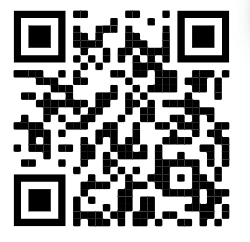


## Install geopack ([details here](https://pypi.org/project/geopack/))

Uses models developed by N. A. Tsyganenko (1989, 1996, 2001, 2004)
Originally written in Fortran 77: [link to the Fortran library](https://ccmc.gsfc.nasa.gov/models/modelinfo.php?model=Tsyganenko%20Magnetic%20Field)

In [27]:
!pip install geopack

In [28]:
from IPython.display import clear_output

## Import the required package and call the functions

In [7]:
import geopack
from geopack import geopack
from geopack.t96 import t96 # other models which can be used: t89, t01, t04
import numpy as np
from dateutil import parser
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

Load IGRF coefficients ...


## Install all Latex dependencies

In [4]:
%%time
!sudo apt-get install aptitude
!sudo aptitude install texlive-fonts-recommended texlive-fonts-extra
!pip install tex
!sudo apt-get -y install texlive-full
!sudo apt-get install dvipng
!sudo apt-get install --fix-missing
!sudo apt-get update
clear_output()

CPU times: user 297 ms, sys: 94.5 ms, total: 392 ms
Wall time: 22.1 s


In [8]:
font = { 'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 10 }
plt.rc( 'font', **font )
plt.rc('text', usetex=True)

In [9]:
geopack?

In [10]:
# Define time
time = '2016-12-24 15:08'

In [11]:
time_utc = parser.parse(time)
time_unix = time_utc.timestamp()
time_unix

1482592080.0

In [12]:
# Compute the field components under the assumption of dipole
xgsm,ygsm,zgsm = [1,2,3] # in radius of earth units
ps = geopack.recalc(time_unix) # dipole tilt angle of the earth

# Compute the dipole field
b0xgsm,b0ygsm,b0zgsm = geopack.dip(xgsm,ygsm,zgsm)

In [13]:
b0xgsm, b0ygsm, b0zgsm

(-467.8721390407777, -646.5015441840932, -418.7106595944902)

#### The magnetospheric magnetic field is a combination of internal magnetic field, comuted using IGRF model, and external magnetic field, computed using T96 model in Geopack.
$R_E$
Way to call the two models and inputs required:

*   IGRF model:

    a) [x, y, z] in GSM coordinate in units of $R_E$

    b) Call the model using ```geopack.igrf_gsm(x, y, z)```


*   T96 model:

    a) Input parameter:

       (i) [x, y, z] in GSM coordinate in units of $R_E$.

       (ii) Solar wind ram pressure in nPa (```p_dyn```). ($P = m_p \cdot n_p \cdot V_p^2 = 1.6726 \times 10^{-6} \cdot n_p \cdot V_p^2$ nPa)

       (iii) DST index (```dst```)

       (iv) Dipole tilt angle (```ps```)

       (v) y- and z-component of IMF ($\vec{B}_{\rm{imf}} \cdot \hat{y}$, and 

       $\vec{B}_{\rm{imf}} \cdot \hat{z}$) (```b_imf_y, b_imf_z```)

    b) Define a ```param``` parameter as ```param = [p_dyn, dst, b_imf_y, b_imf_z, 0, 0, 0, 0, 0, 0]``` (the 6 zeros at the end is for some progmatic reasons).

    c) Call the model using ```t96(param, ps, x, y, z)```

In [14]:
time = '2016-12-24 15:08'
time_utc = parser.parse(time)
time_unix = time_utc.timestamp()

ps = geopack.recalc(time_unix) # Compute the dipole tilt angle

In [15]:
n_p = 5 # /cm^{-3}
v_p = 500 # km/s
b_imf_x = -5 # nT
b_imf_y = 2 # nT
b_imf_z = 1 # nT

dst = -20

p_dyn = 1.6726e-6 * n_p * v_p**2 # nPa

In [16]:
%%time
n_arr = 160
bx_igrf = np.full((n_arr, n_arr), np.nan)
by_igrf = np.full((n_arr, n_arr), np.nan)
bz_igrf = np.full((n_arr, n_arr), np.nan)

bx_t96 = np.full((n_arr, n_arr), np.nan)
by_t96 = np.full((n_arr, n_arr), np.nan)
bz_t96 = np.full((n_arr, n_arr), np.nan)

bx = np.full((n_arr, n_arr), np.nan)
by = np.full((n_arr, n_arr), np.nan)
bz = np.full((n_arr, n_arr), np.nan)

x_arr = 10
y_arr = np.linspace(-40, 40, n_arr)
z_arr = np.linspace(-40, 40, n_arr)

param = [p_dyn, dst, b_imf_y, b_imf_z, 0, 0, 0, 0, 0, 0]

for (j,y) in enumerate(y_arr):
    for (k,z) in enumerate(z_arr):
        bx_igrf[j, k], by_igrf[j, k], bz_igrf[j, k] = geopack.igrf_gsm(x_arr, y, z)
        bx_t96[j, k], by_t96[j, k], bz_t96[j, k] = t96(param, ps, x_arr, y, z)

        bx[j, k] = bx_t96[j, k] + bx_igrf[j, k]
        by[j, k] = by_t96[j, k] + by_igrf[j, k]
        bz[j, k] = bz_t96[j, k] + bz_igrf[j, k]

CPU times: user 6.02 s, sys: 1.01 ms, total: 6.02 s
Wall time: 6.03 s


In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

In [24]:
np.nanmin(bz), np.nanmax(bz)

(-15.487467905203285, 40.93861730604931)

In [19]:
cmap = plt.cm.viridis

pad = 0.02
clabelpad = 10
labelsize = 18
ticklabelsize = 15
cticklabelsize = 15
clabelsize = 15
ticklength = 3
tickwidth = 1.5
ticklength = 6
mticklength = 4
cticklength = 5
mcticklength = 4
labelrotation = 0

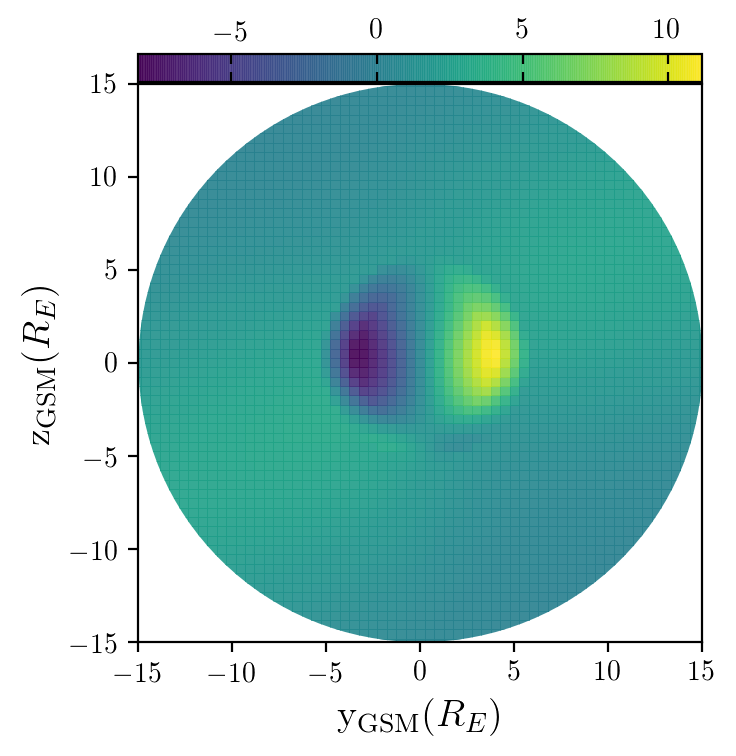

In [26]:
# Define the figure
fig = plt.figure(num=None, figsize=(3, 3), dpi=200, facecolor='w', edgecolor='gray')
fig.subplots_adjust(left=0.01, right=0.95, top=0.99, bottom=0.01, wspace=0.02, hspace=0.)

comp = by

# Define the colorbar norm
norm = mpl.colors.Normalize(vmin=np.nanmin(comp), vmax=np.nanmax(comp))

# Define the axes in the figure
axs1 = fig.add_subplot(1, 1, 1)

im1 = axs1.pcolormesh(y_arr, z_arr, np.transpose(comp), alpha=0.9, shading='auto', cmap=cmap,
                      norm=norm)
patch = patches.Circle((0, 0), radius=15, transform=axs1.transData)
im1.set_clip_path(patch)

axs1.set_xlim(-15, 15)
axs1.set_ylim(-15, 15)

axs1.set_xlabel( r'$\mathrm{y_{GSM}} ( R_E )$', fontsize=14 )
axs1.set_ylabel( r'$\mathrm{z_{GSM}} ( R_E )$', fontsize=14 )

# Create a new axis for colorbar
divider1 = make_axes_locatable(axs1)

cax1 = divider1.append_axes("top", size="5%", pad=0.01 )
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal', ticks=None, fraction=0.05, pad=0.01)

cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.tick_params(axis='x', direction='in', labeltop=True, labelbottom=False, color='k',top=True,
                     bottom=True)

In [21]:
np.nanmax(y_arr)

40.0